# Tutorial 4.1: The Hodgkin-Huxley Model as an Oscillator

### Neuroscience goal:
- gain appreciation of the type-II properties of the Hodgkin-Huxley model

### Computational goal:
- careful transposition of mathematical formulae and parameters into computer code
- practice of simulations with several interdependent variables

### Overview
- simulate a full four-variable model similar to original H-H model
    - sodium activation (*m*)
    - sodium inactivation (*h*)
    - potassium activation (*n*)
    - membrane potential (*V*)
    
- all four variables will be updated on each timestep (they depend on each other)
- initial conditions should be 0 for all gating variables and e_leak for the membrane potential, unless otherwise stated
    

In [273]:
import numpy as np
import matplotlib.pyplot as plt

In [274]:
def reset_params():
    """reset global parameters and initialize simulation variables"""
    global g_leak, g_na, g_k, e_na, e_k, e_leak, c_membrane
    
    g_leak = 30e-9         # Leak conductance, nS
    g_na = 12e-6           # Maximum sodium conductance, uS
    g_k = 3.6e-6           # Maximum potassium conductance, uS
    e_na = 45e-3           # Sodium reversal potential, mV
    e_k = -82e-3           # Potassium reversal potential, mV
    e_leak = -60e-3        # Leak reversal potential, mV
    c_membrane = 100e-12   # Membrane capacitance, pF
    
reset_params()

### Set up a simulation of 0.35s duration of HH model as follows:

In [570]:
def hhsim(t, i_app, v_init=-61e-3, m_init=0, h_init=0, n_init=0):
    reset_params()
    # initialize simulation vectors
    v_sim = np.zeros_like(t)
    m_sim = np.zeros_like(t)
    h_sim = np.zeros_like(t)
    n_sim = np.zeros_like(t)

    # gating variable initial conditions
    v_sim[0] = v_init
    m_sim[0] = m_init
    h_sim[0] = h_init
    n_sim[0] = n_init

    
    for i in range(1, t.shape[0]):
                
        # membrane potential ODE terms
        leak_term = g_leak * (e_leak - v_sim[i - 1])
        na_term = g_na * (m_sim[i - 1] ** 3) * (h_sim[i - 1]) * (e_na - v_sim[i - 1])
        k_term = g_k * (n_sim[i - 1] ** 4) * (e_k - v_sim[i - 1])
        
        # membrane potential ODE
        dvdt = (leak_term + na_term + k_term + i_app[i - 1]) / c_membrane
        # forward Euler update
        v_sim[i] = v_sim[i - 1] + (dt*dvdt)
        
        # update gating variable ODEs 
    
        # m_sim
        alpha_m = ((10**5) * (-v_sim[i - 1] - 0.045)) / (np.exp(100 * (-v_sim[i - 1] - 0.045)) - 1)
        beta_m = 4 * 10**3 * (np.exp((-v_sim[i - 1] - 0.070) / 0.018))
        tau_m = 1 / (alpha_m + beta_m)
        # update m_sim ODE
        dmdt = alpha_m * (1 - m_sim[i - 1]) - (beta_m * m_sim[i - 1])
        m_sim[i] = m_sim[i - 1] + (dmdt * dt)
        
        # h_sim
        alpha_h = 70 * (np.exp(50 * (-v_sim[i - 1] - 0.070)))
        beta_h = (10**3) / (1 + np.exp(100 * (v_sim[i - 1] - 0.040)))
        tau_h = 1 / (alpha_h + beta_h)
        # update h_sim
        dhdt = alpha_h * (1 - h_sim[i - 1]) - (beta_h * h_sim[i - 1])
        h_sim[i] = h_sim[i - 1] + (dhdt * dt)
        
        # n_sim
        alpha_n = (10**4 * (-v_sim[i - 1] - 0.060)) / (np.exp(100 * (-v_sim[i - 1] - 0.060)) - 1)
        beta_n = 125 * np.exp((-v_sim[i - 1] - 0.070) / 0.08)
        tau_n = 1 / (alpha_n + beta_n)
        # update n_sim
        dndt = alpha_n * (1 - n_sim[i - 1]) - (beta_n * n_sim[i - 1])
        n_sim[i] = n_sim[i - 1] + (dndt * dt)
        
    return v_sim #, m_sim, h_sim, n_sim
        

In [563]:
# set up time vector 
def reset_time(tmax, dt):

    global t
    t = np.arange(0, tmax, dt)
    

In [564]:
i_app = np.zeros_like(t)

In [748]:
def plot_iv(i_app, v):
    """plots applied current above membrane response"""
    fig, ax = plt.subplots(2, 1, figsize=(8, 4))
    
    ax[0].plot(i_app)
    ax[0].set_ylabel('$I_{app}$ (A)')

    ax[1].plot(v)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('$V_m$ (V)')
    plt.tight_layout()
    plt.show()

### a. *initially set applied current to zero and check membrane potential stabilizes at -70.2mV*

In [749]:
reset_time(0.35, 1e-4)

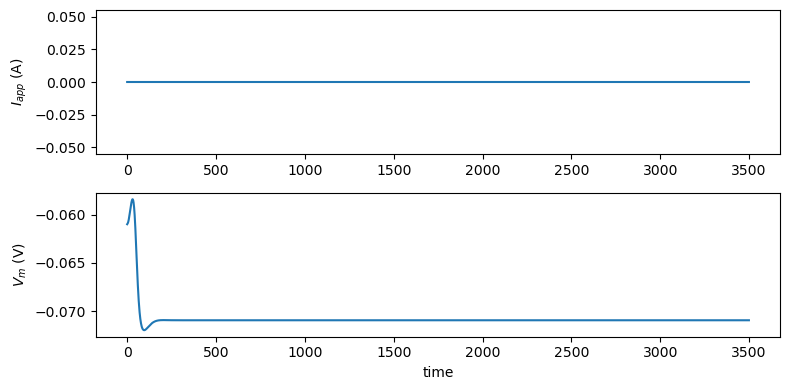

In [750]:
i_app = np.zeros_like(t)
v = hhsim(t, i_app)
plot_iv(i_app, v)

### b. produce applied curent vector with baseline of 0 and steps up to 0.22nA for a duration of 100msbeginning at a time of 100ms. 
- plot applied current on an upper graph and membrane response on lower graph of same figure

In [751]:
i_app = np.zeros_like(t)
i_app[1000:2000] = 0.22e-9 # gotta get these units right :0


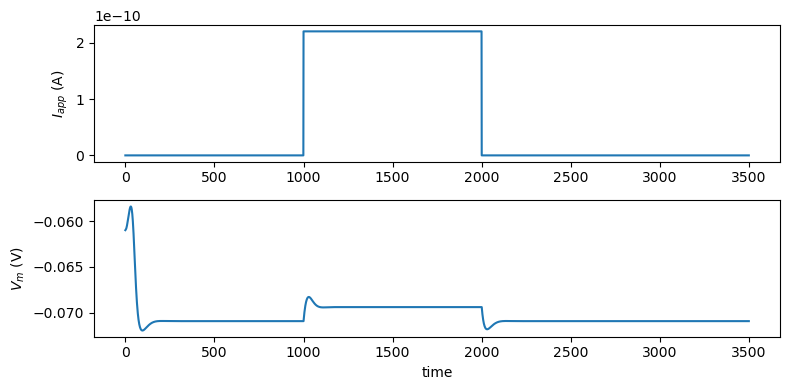

In [752]:
v = hhsim(t, i_app)
plot_iv(i_app, v)

### c. change applied current to be a series of 10 pulses, each of 5ms duratoin and 0.22nA amplitude
- create a parameter that defines the delay from the onset of one pulse to the onset of the next pulse.
- adjust delay from minimum of 5ms up to 25ms and plot applied current and membrane potential as in (b) for two to three examples of pulse separations that generate spikes
- be careful to repeat simulation with time step reduced by factor of 10 to ensure you see no change in response as a sign you have sufficient accuracy in simulation.
    - timestep as low as 0.2us might be necessary

In [753]:
reset_params()
reset_time(0.35, 0.1e-3)

In [754]:
i_app = np.zeros_like(t)
pulse_duration = 50
pulse = np.ones(pulse_duration) * 0.22e-8
pulse_period = 100

for i in range(1, 9):
    pulse_start = i * pulse_period
    pulse_end = pulse_start + pulse_duration
    i_app[pulse_start:pulse_end] = pulse


In [755]:
def create_pulse_current(n_pulses, duration, delay, i_app, intensity):
    for i in range(1, n_pulses+1):
        pulse_start = i * delay
        pulse_end = pulse_start + duration
        i_app[pulse_start:pulse_end] = intensity
    
    return i_app

In [756]:
pulse_delays = np.arange(50, 251, 50)
i_app = np.zeros_like(t)
pulse_currents = np.zeros((len(pulse_delays), len(i_app)))
    
for idx, delay in enumerate(pulse_delays):
    pulse_current = create_pulse_current(10, 50, delay, np.copy(i_app), 0.22e-9)
    pulse_currents[idx, :] = pulse_current

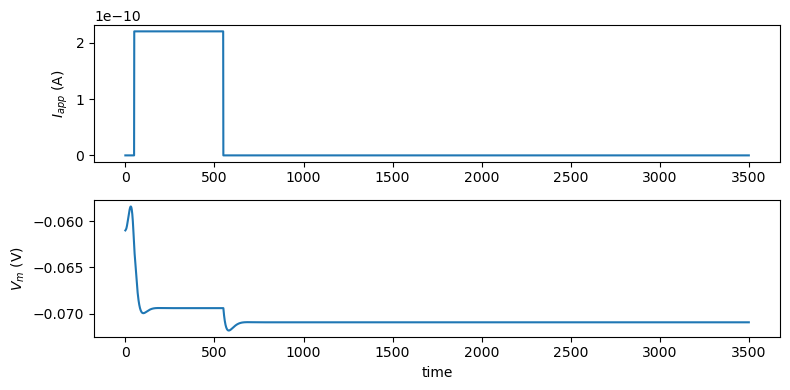

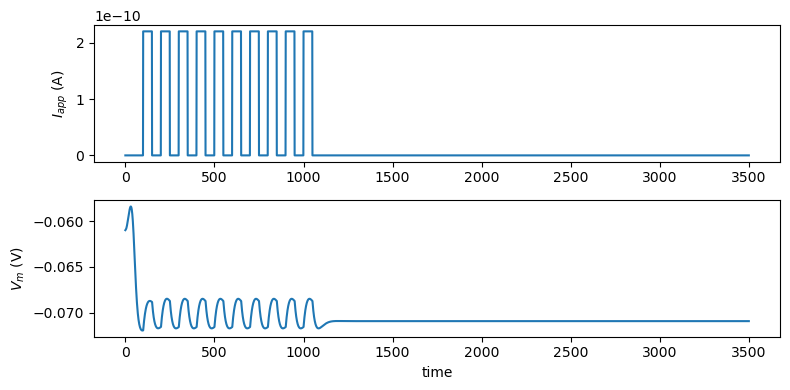

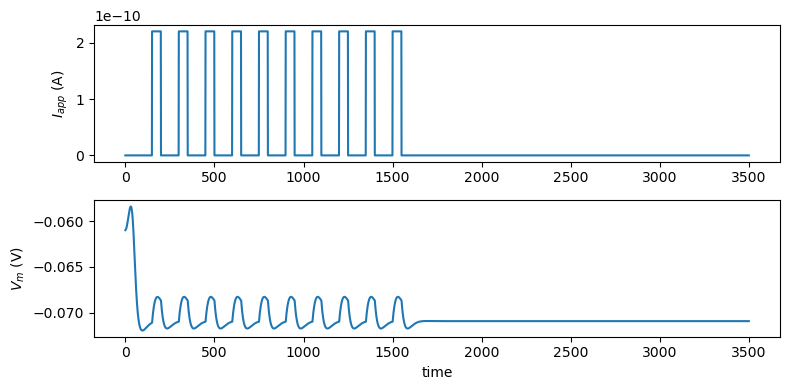

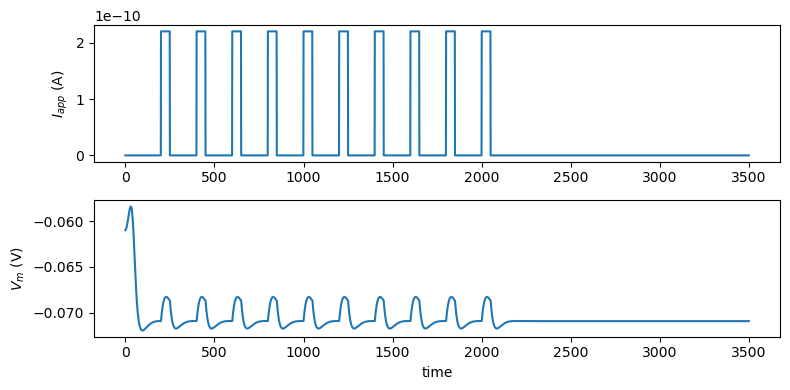

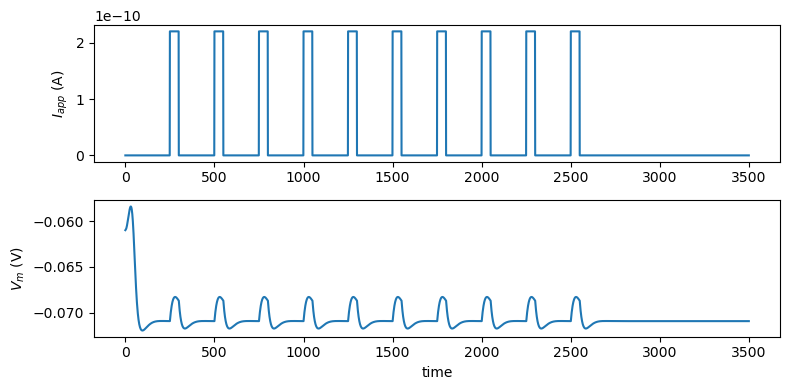

In [757]:
for i in pulse_currents:
    v = hhsim(t, i)
    plot_iv(i, v)

### d. set baseline current to 0.6nA. 
- initial conditions as v_sim[0] = -0.065V
    - m_sim[0] = 0.05
    - h_sim[0] = 0.5
    - n_sim[0] = 0.35
- apply a series of 10 inhibitory pulses to brng the applide current to zero for a duration of 5ms, with pulse onsets 20ms apart
- plot applied current and membrane potential's response

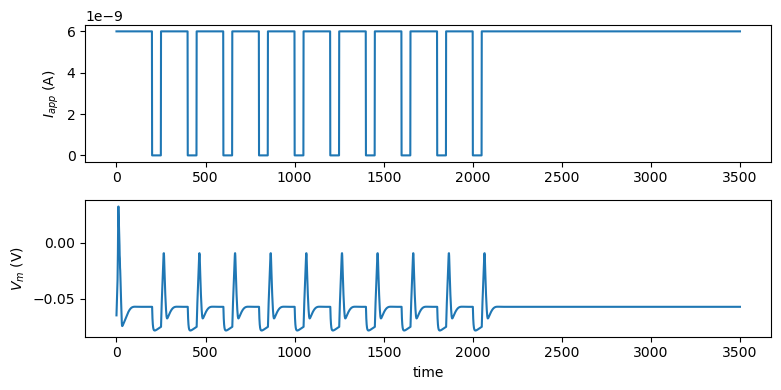

In [801]:
i_app = np.full_like(t, 0.6e-8)
inhibitory_pulse = create_pulse_current(10, 50, 200, np.copy(i_app), 0)
v = hhsim(t, inhibitory_pulse, v_init=-0.065, m_init=0.05, h_init=0.5, n_init=0.35)
plot_iv(inhibitory_pulse, v)

### e. set baseline current to 0.65nA
- set initial conditions:
    - v_sim[0] = -0.065
    - m[0] = 0.05
    - h_sim[0] = 0.5
    - n_sim[0] = 0.35
- increase excitatory current to 1nA for a 5ms pulse at the time point of 100ms
- plot applied current and resulting behavior

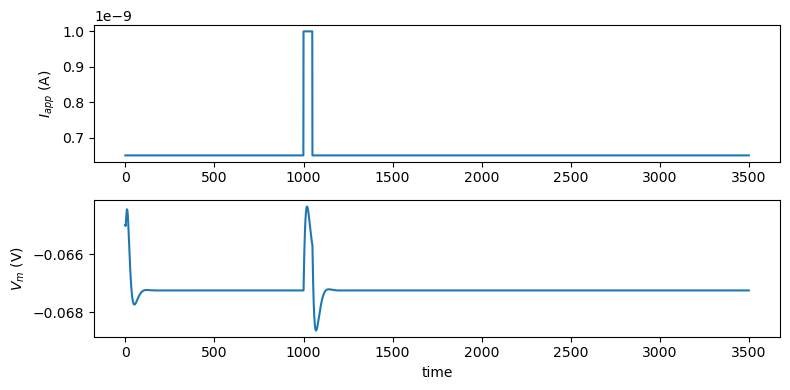

In [829]:
i_app = np.full_like(t, 0.65e-9)
i_app[1000:1050] = 1e-9
v = hhsim(t, i_app, v_init=-0.065, m_init=0.05, h_init=0.5, n_init=0.35)
plot_iv(i_app, v)

### f. repeat e with basline current of 0.7nA:
- set initial conditions:
    - v_sim[0] = -0.065
    - m_sim[0] = 0
    - h_sim[0] = 0
    - n_sim[0] = 0
- increase excitatory current to 1nA for 5ms pulse at time point 100ms
- plot applied current and resulting behavior

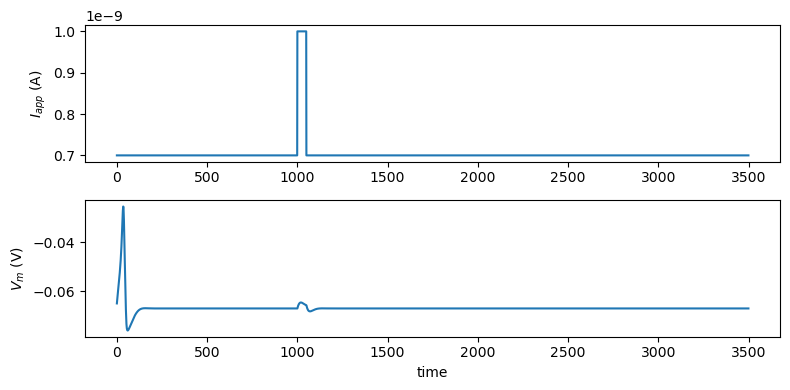

In [830]:
i_app = np.full_like(t, 0.7e-9)
i_app[1000:1050] = 1e-9
#v = hhsim(t, i_app, v_init=-0.065, m_init=0.05, h_init=0.5, n_init=0.35)

v = hhsim(t, i_app, v_init=-0.065, m_init=0, h_init=0, n_init=0)
plot_iv(i_app, v)